In [2]:
from models.stage1.vq import VectorQuantize
from utils import load_yaml_param_settings, quantize
import numpy as np
import pandas
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
conf_dir = 'configs/config.yaml'

config = load_yaml_param_settings(conf_dir)

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dim = 64
vq = VectorQuantize(dim, config["VQVAE"]["codebook"]["size"], **config["VQVAE"])

#load the vq model
dir = 'saved_models/vqmodel-FordA.ckpt'
vq.load_state_dict(torch.load(dir))

<All keys matched successfully>

In [4]:
vq._codebook.training = True
print(vq._codebook.training)
z = torch.rand(256, 64, 5, 8)
codebook = vq.codebook
l = quantize(z, vq)
codebook2 = vq.codebook
print(torch.sum(codebook == codebook2, dim = 1))

True
tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64])


In [5]:
codebook = vq.codebook

codebook_norm = codebook / torch.norm(codebook, dim=1, keepdim=True)

corr = torch.corrcoef(codebook_norm)
torch.sum(torch.abs(corr - torch.eye(corr.shape[0]))) / (corr.shape[0] * (corr.shape[0] - 1))

tensor(0.3629)

In [6]:
cosine_similarity = F.cosine_similarity(codebook_norm.unsqueeze(0), codebook_norm.unsqueeze(1), dim=2)
torch.sum(torch.abs(cosine_similarity - torch.eye(cosine_similarity.shape[0]))) / (cosine_similarity.shape[0] * (cosine_similarity.shape[0] - 1))

tensor(0.3552)

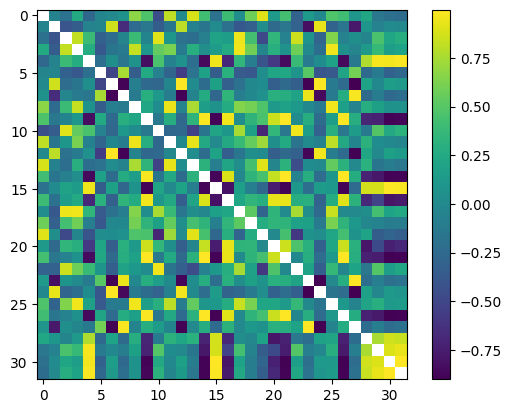

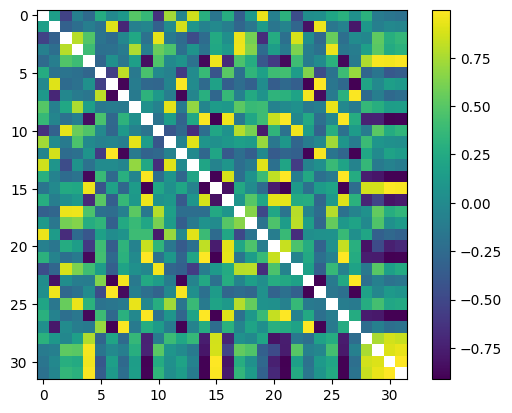

In [7]:
corr.fill_diagonal_(np.nan)
cosine_similarity.fill_diagonal_(np.nan)

plt.imshow(cosine_similarity)
plt.colorbar()
plt.show()
plt.close()
plt.imshow(corr)
plt.colorbar()
plt.show()

In [42]:
def enhanced_decorrelation_loss(codebook, device):
    # Compute the correlation matrix of the codebook vectors
    corr = torch.corrcoef(codebook).to(device)
    # Create an identity matrix for reference (perfect decorrelation)
    identity = torch.eye(corr.shape[0]).to(device)
    # Calculate the squared difference from the identity matrix for off-diagonal elements
    # This squares the correlation values, penalizing higher correlations more
    squared_diff = (corr - identity) ** 2
    # We zero out the diagonal because we are only interested in off-diagonal elements
    squared_diff = squared_diff * (1 - identity)
    # Sum up all the squared differences and normalize by the number of off-diagonal elements
    decorr_loss = torch.sum(squared_diff) / (corr.shape[0] * (corr.shape[0] - 1))
    return decorr_loss 

In [43]:
print(enhanced_decorrelation_loss(codebook, 'cuda:0'))

tensor(0.2229, device='cuda:0')


In [44]:

def abs_correlation_loss(codebook, device):
    corr_matrix = torch.abs(torch.corrcoef(codebook).to(device))

    # Create an identity matrix of the same size as the covariance matrix
    identity_matrix = torch.eye(corr_matrix.size(0)).to(device)

    # Calculate loss as the sum of squared off-diagonal elements of the covariance matrix
    # This is equivalent to minimizing the Frobenius norm of the off-diagonal elements
    off_diagonal_mask = 1 - identity_matrix
    off_diagonal_elements = corr_matrix * off_diagonal_mask
    decorr_loss = torch.norm(off_diagonal_elements, p="fro") ** 2 / (
        corr_matrix.size(0) * (corr_matrix.size(0) - 1)
    )

    return decorr_loss

def correlation_loss(codebook, device):

    corr_matrix = torch.corrcoef(codebook).to(device)

    # Create an identity matrix of the same size as the covariance matrix
    identity_matrix = torch.eye(corr_matrix.size(0)).to(device)

    # Calculate loss as the sum of squared off-diagonal elements of the covariance matrix
    # This is equivalent to minimizing the Frobenius norm of the off-diagonal elements
    off_diagonal_mask = 1 - identity_matrix
    off_diagonal_elements = corr_matrix * off_diagonal_mask
    decorr_loss = torch.norm(off_diagonal_elements, p="fro") ** 2 / (
        corr_matrix.size(0) * (corr_matrix.size(0) - 1)
    )

    return decorr_loss


def covariance_loss(codebook, device):

    codebook_mean = torch.mean(codebook, dim=0, keepdim=True)
    codebook_centered = codebook - codebook_mean
    cov_matrix = torch.matmul(codebook_centered.T, codebook_centered) / (
        codebook.size(0) - 1
    )

    # Create an identity matrix of the same size as the covariance matrix
    identity_matrix = torch.eye(cov_matrix.size(0)).to(device)

    # Calculate loss as the sum of squared off-diagonal elements of the covariance matrix
    # This is equivalent to minimizing the Frobenius norm of the off-diagonal elements
    off_diagonal_mask = 1 - identity_matrix
    off_diagonal_elements = cov_matrix * off_diagonal_mask
    decorr_loss = torch.norm(off_diagonal_elements, p="fro") ** 2 / (
        cov_matrix.size(0) * (cov_matrix.size(0) - 1)
    )

    return decorr_loss


In [45]:
test = torch.rand_like(codebook)
print(covariance_loss(codebook, 'cpu'), "random", covariance_loss(test, 'cpu'))
print(correlation_loss(codebook, 'cpu'), "random", correlation_loss(test, 'cpu'))
print(abs_correlation_loss(codebook, 'cpu'), "random", abs_correlation_loss(test, 'cpu'))

tensor(3.1981) random tensor(0.0002)
tensor(0.2229) random tensor(0.0151)
tensor(0.2229) random tensor(0.0151)


In [18]:
def exponential_weight_schedule(
    current_epoch, max_epoch, start_weight, end_weight, base=2
):
    if current_epoch > max_epoch:
        return end_weight
    else:
        epoch_ratio = current_epoch / max_epoch
        weight = start_weight + (end_weight - start_weight) * (
            (base**epoch_ratio) - 1
        ) / (base - 1)
        return weight

In [12]:
import torch
a = torch.tensor([1.0,2.0,3.0,4.0,5.0], requires_grad=True)
l = torch.sum(a.detach())
print(a.requires_grad)

True


In [10]:
class WeightedEMA:
    def __init__(self, decay_rate):
        self.decay_rate = decay_rate
        self.value = None

    def update(self, new_value, importance=1.0):
        if self.value is None:
            self.value = new_value
        else:
            self.value = self.decay_rate * importance * new_value + (1 - self.decay_rate) * self.value

    def get_ema(self):
        return self.value


# Example usage
if __name__ == "__main__":
    # Initialize Weighted EMA with a decay rate
    weighted_ema = WeightedEMA(decay_rate=0.2)

    # Example data with importance factors
    data_with_importance = [(10, 0.8), (15, 0.6), (20, 1.0), (25, 0.9), (30, 0.7)]

    # Update Weighted EMA with each data point and print the result
    for value, importance in data_with_importance:
        weighted_ema.update(value, importance)
        ema_value = weighted_ema.get_ema()
        print(f"New value: {value}, Importance: {importance}, Weighted EMA: {ema_value}")

    # Output:
    # New value: 10, Importance: 0.8, Weighted EMA: 8.0
    # New value: 15, Importance: 0.6, Weighted EMA: 9.0
    # New value: 20, Importance: 1.0, Weighted EMA: 14.6
    # New value: 25, Importance: 0.9, Weighted EMA: 19.72
    # New value: 30, Importance: 0.7, Weighted EMA: 23.4048


New value: 10, Importance: 0.8, Weighted EMA: 10
New value: 15, Importance: 0.6, Weighted EMA: 9.8
New value: 20, Importance: 1.0, Weighted EMA: 11.84
New value: 25, Importance: 0.9, Weighted EMA: 13.972000000000001
New value: 30, Importance: 0.7, Weighted EMA: 15.377600000000001


In [24]:
codebook = vq.codebook

codebook_normalized = (codebook - codebook.mean(dim=0)) / codebook.std(dim=0)

C = torch.cov(codebook_normalized)
C_diag = torch.diag(C, 0)

loss = (torch.norm(C, "fro") ** 2 - torch.norm(C_diag, 2) ** 2) / (C.shape[0] * (C.shape[0] - 1))

loss

tensor(0.1780)

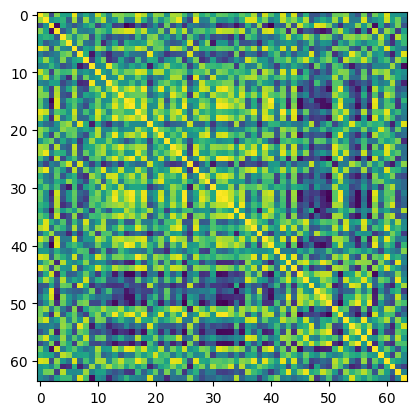

In [32]:
plt.imshow(C)

torch.Size([32, 64])

In [17]:
codebook.shape

torch.Size([32, 64])

In [7]:
import torch
from models.stage2.byol_maskgit import BYOLMaskGIT
from utils import get_root_dir, load_yaml_param_settings
from preprocessing.data_pipeline import build_data_pipeline
from preprocessing.preprocess_ucr import UCRDatasetImporter
import numpy as np
from experiments.exp_byol_maskgit import ExpBYOLMaskGIT
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
import wandb

config_dir = get_root_dir().joinpath("configs", "config.yaml")
config = load_yaml_param_settings(config_dir)

batch_size = config["dataset"]["batch_sizes"]["stage1"]

dataset_importer = UCRDatasetImporter(**config["dataset"])

train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="train"
)

test_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="test"
)

n_classes = len(np.unique(train_data_loader.dataset.Y))
input_length = train_data_loader.dataset.X.shape[-1]

exp = ExpBYOLMaskGIT(
    n_classes=n_classes,
    input_length=input_length,
    config=config,
    n_train_samples=len(train_data_loader.dataset),
)


self.X_train.shape: (3601, 500)
self.X_test.shape: (1320, 500)
# unique labels (train): [0 1]
# unique labels (test): [0 1]
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_0.1_orthogonal_double_encoder-FordA.ckpt
vibcreg encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_0.1_orthogonal_double_decoder-FordA.ckpt
vibcreg decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_0.1_orthogonal_double_vqmodel-FordA.ckpt
vibcreg vqmodel loaded


In [9]:

online_transformer_params_before = [param.clone() for param in exp.byol_maskgit.online_transformer.parameters()]
target_transformer_params_before = [param.clone() for param in exp.byol_maskgit.target_transformer.parameters()]

torch.set_grad_enabled(True)

wandb.init()

wandb_logger = WandbLogger(
        config=config,
        mode="disabled"
    )

trainer = pl.Trainer(
    enable_checkpointing=False,
    callbacks=[LearningRateMonitor(logging_interval="epoch")],
    max_epochs=1,
    devices=[
        0,
    ],
    accelerator="gpu",
    check_val_every_n_epoch=1,
)
trainer.fit(
    exp,
    train_dataloaders=train_data_loader,
)

online_transformer_params_after = [param.clone() for param in exp.byol_maskgit.online_transformer.parameters()]
target_transformer_params_after = [param.clone() for param in exp.byol_maskgit.target_transformer.parameters()]


[tensor([[ 0.0389, -0.0437, -0.0412,  ..., -0.0567,  0.0244,  0.0000],
        [-0.0033, -0.0555, -0.0453,  ..., -0.0260,  0.0163,  0.0000],
        [ 0.0198, -0.0507, -0.0484,  ..., -0.0661,  0.0131,  0.0000],
        ...,
        [-0.0207,  0.0572,  0.0026,  ..., -0.0552, -0.0224,  0.0000],
        [-0.0169,  0.0563, -0.0493,  ..., -0.0334, -0.0177,  0.0000],
        [-0.0258,  0.0506, -0.0505,  ..., -0.0300, -0.0163,  0.0000]],
       device='cuda:0', grad_fn=<CloneBackward0>), tensor([[ 1.0604, -1.1833,  0.4455,  ...,  1.7370,  0.4009,  2.1376],
        [-0.5654,  0.7800, -0.6499,  ..., -0.7012, -0.2622, -0.2745],
        [-0.4673,  0.7326, -0.6545,  ..., -0.6038, -0.0694, -0.4075],
        ...,
        [ 1.3159, -1.7958,  1.8937,  ...,  2.1779,  2.0669,  0.8235],
        [ 0.5611, -1.4163, -0.1746,  ...,  0.8122, -0.4530,  0.4215],
        [ 0.1415, -1.1920, -0.7205,  ..., -0.3072, -1.2453,  0.0910]],
       device='cuda:0', grad_fn=<CloneBackward0>), tensor([[-0.0535, -1.5808, -0

loss,▄█▂▃▂▂▁▂▂▂▂▁▁▃▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁▂▁▂▁▁▁▁▂▁
prior_loss,▃█▂▃▂▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
vibcreg_loss,██▃▃▃▃▂▃▃▃▂▂▂█▂▂▃▂▂▁▃▂▂█▁▁▃▁▁▃▂▃▂▂▁▂▁▁▃▁
loss,3.36747
prior_loss,0.79953
vibcreg_loss,2.56793


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type        | Params
---------------------------------------------
0 | byol_maskgit | BYOLMaskGIT | 2.9 M 
1 | ssl_method   | VIbCReg     | 34.2 M
---------------------------------------------
36.4 M    Trainable params
631 K     Non-trainable params
37.1 M    Total params
148.303   Total estimated model params size (MB)
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (29) is smaller than the logging interval Trainer(log_e

Epoch 0:  62%|██████▏   | 18/29 [00:01<00:01,  9.52it/s, v_num=7]

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
